# Text Prediction using Recurrent Neural Networks

Text prediction is a task that we use so often in our lives that we've taken it for granted. From the auto-fill feature in our messaging apps to search engines predicting search terms, text prediction technology saves our time and helps us to make our lives easier. It also links into other tasks such as text generation, which can eventually be used to write stories or longer paragraphs.

In this notebook, I will be using the <b>Brown corpus</b> to create and train a LSTM model to predict the next word in a sentence.


## Table of Contents



Loading the Data

Preprocessing

Cleaning the Data

Vectorizing Words

Visualizing Word Vectorization with Parts of Speech

Sliding Window

The RNN

LSTM

Evaluation

Training Other Corpora



## Loading the Data

I'll start by importing the usual data science libraries.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

I am going to download the <b>Brown corpus</b> from the natural language processing <b>module nltk</b>.I had choosen the Brown corpus because it was the first million-word electronic corpus of English, created in 1961 at Brown University. This corpus contains text from 500 sources, and the sources have been categorized by genre, such as news, editorial, and so on.(for a complete list, see https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html).
The data is in the form of tokenized sentences, and I'll store it into a dataframe "df".

In [2]:
nltk.download('brown')
nltk.download('punkt')
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer

text = np.empty(0)
for fileid in brown.fileids():
    temp = np.array(brown.sents(fileid)).reshape(-1, 1)
    text = np.append(text, temp)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
df = pd.DataFrame(text, columns = ['tokenized_sentences'])

Let's add a <b>second column called sentences</b>, which is just the regular, untokenized sentences.

In [0]:
def sentence_maker(tokenized_sentence):
  result = ' '.join(tokenized_sentence)
  result = result.replace(' ,', ',')
  result = result.replace(' .', '.')
  return result

In [5]:
df['sentences'] = df['tokenized_sentences'].map(sentence_maker)
df.head()

,tokenized_sentences,sentences
0,"[The, Fulton, County, Grand, Jury, said, Frida...",The Fulton County Grand Jury said Friday an in...
1,"[The, jury, further, said, in, term-end, prese...",The jury further said in term-end presentments...
2,"[The, September-October, term, jury, had, been...",The September-October term jury had been charg...
3,"[``, Only, a, relative, handful, of, such, rep...",`` Only a relative handful of such reports was...
4,"[The, jury, said, it, did, find, that, many, o...",The jury said it did find that many of Georgia...


Here, we can see the very first sentences of <b>The Fulton County Grand Jury said Friday</b>. 


## Preprocessing

## Cleaning the Data

Now, I'll set all the <b>words to lower case</b>, so that our model won't differentiate things like Jury and jury.

In [0]:
def clean_sents(arr):
  result = [word.lower() for word in arr]
  return result

In [14]:
df['tokenized_sentences'] = df['tokenized_sentences'].map(clean_sents)
df.head()

,tokenized_sentences,sentences
0,"[the, fulton, county, grand, jury, said, frida...",The Fulton County Grand Jury said Friday an in...
1,"[the, jury, further, said, in, term-end, prese...",The jury further said in term-end presentments...
2,"[the, september-october, term, jury, had, been...",The September-October term jury had been charg...
3,"[``, only, a, relative, handful, of, such, rep...",`` Only a relative handful of such reports was...
4,"[the, jury, said, it, did, find, that, many, o...",The jury said it did find that many of Georgia...


Hope it helps! Now let's move on to vectorizing our words and encoding them in a way that an RNN can read and learn from.

### Vectorizing Words

An <b>RNN can't take in a variable length input like a sentence, so i need to encode my inputs into vectors</b>. I'll be using the <b>Word2Vec embedding</b>, which is just a shallow, <b>two-layer neural network that's trained to represent sentences as high-dimensional vectors which preserve the linguistic context of each sentence</b>. I going to use a library called <b>"gensim"</b>, which contains tons of useful functions for natural language processing and word encoding. Using gensim, I can train my Word2Vec model to encode words as vectors.

In [0]:
#!pip install --upgrade gensim

In [0]:
from gensim.models import Word2Vec
def create_w2v_model(df, epochs):
  w2v_model = Word2Vec(df['tokenized_sentences'])
  w2v_model.train(df['tokenized_sentences'], total_examples=len(df['tokenized_sentences']), epochs=10)
  return w2v_model

In [0]:
w2v_model = create_w2v_model(df, 50)

Great! Now  I've trained my model, I can output a sample vector. Below is Word2Vec's encoding of the word "news.''

In [15]:
print(w2v_model.wv['city'])

[ 0.9662233  -0.1160216   0.36450958  1.2231109  -0.03014357 -1.3861514
 -0.56628984 -0.30484074  0.92908174  0.77510774 -0.24576303  0.487494
 -0.11693805 -1.0784466   0.7045526  -1.2436638   1.344843    0.17755267
  0.45998678 -1.1154763   1.4678504  -0.04600672  0.37584448 -0.17989126
 -0.9826546  -0.4744938   1.3980793  -0.16804409  0.91153747 -1.0509945
  1.334058   -0.927363    0.04772428 -0.36780825  0.71029514  1.0509741
  1.2796918   1.1534647   1.1108794  -1.0837885   1.3530561  -0.512633
  1.3641227   0.7936887   0.6340509  -0.2363175   1.2176833  -0.39846048
 -0.7919116  -0.4732624   0.0708878  -1.265357   -2.8480911   1.3082633
 -0.08859403 -1.0259267  -0.30420396  0.6880478  -1.2955552   0.15912667
  0.27987307  0.2113406  -0.16067648 -0.3657929   0.41358554  0.8764315
 -1.7657287  -0.27940884 -0.33175144  0.68550026 -0.14510846  0.62778956
  0.71472937  0.6035756  -1.0760717  -1.7300105   0.51020455 -1.5141939
  0.28757244 -0.5070724   0.9002349   0.2622307   0.5516733  

To get an idea of what Word2Vec is doing, we can call most_similar on a few sentences. This function tries to find the words with the highest similarity using the word vectors of the words. This may help us better understand what the vectorization is actually doing.

In [16]:
print('School:', w2v_model.wv.most_similar('school', topn = 3))
print('Smell:', w2v_model.wv.most_similar('smell', topn = 3))
print('Election:', w2v_model.wv.most_similar('election', topn = 3))

School: [('college', 0.7335516214370728), ('schools', 0.7091710567474365), ('junior', 0.6243978142738342)]
Smell: [('snake', 0.7300702929496765), ('laugh', 0.7028021216392517), ('flash', 0.6783021688461304)]
Election: [('campaign', 0.7557293176651001), ('council', 0.7407146692276001), ('publication', 0.6884081363677979)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


As we can see, Word2Vec has learned something about the context of each word, as the outputs of most_similar seem to somewhat match up with each word. However, Word2Vec isn't perfect - some suggestions for 'Smell' and 'Election' don't make that much sense.

### Visualizing Word Vectorization with Parts of Speech

Let's see if we can visualize how Word2Vec is encoding our words. We'll need to reduce the dimensionality of each word's vector to plot, so let's use PCA.

In [17]:
from sklearn.decomposition import PCA

X = w2v_model[w2v_model.wv.vocab]
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


With our reduced data, let's now visualize our words using a scatterplot colored by parts of speech. Let's see how good of a job of Word2Vec did. First, we'll need to get a list of unique words, as there's going to be a lot of repeated words in our dataset. To do so, we can use <b>gensim's wv.vocab, </b>which will return the list of unique words in the data.

In [18]:
unique_words = list(w2v_model.wv.vocab)
print('Number of unique words:', len(unique_words))

Number of unique words: 14221


Now, let's get the parts of speech, for each word, so we can color our data points. Luckily, nltk has <b>averaged_perceptron_tagger</b>, which can tag words with their part of speech. We can now go through and add a new column to our dataset, df_tag, the part of speech for each word.

In [19]:
nltk.download('averaged_perceptron_tagger')
df_tag = pd.DataFrame(nltk.pos_tag(unique_words))
df_tag.rename(columns={0: "word", 1: "pos"}, inplace= True)
df_tag.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,word,pos
0,the,DT
1,fulton,NN
2,county,NN
3,grand,JJ
4,jury,NN


Now we have the part of speech for each word, we can create a color map. There seems to be a lot of categories for parts of speech, so we can just generate a random color for each part of speech that hasn't been assigned a color. With our finished color map, we can go ahead and plot our data. I've annotated a small sample of words to help with the visualization.

Additional information--

<b>IN: Preposition or subordinating conjunction</b>

<b>NN: Noun, singular or mass</b>

<b>DT: determiner</b>

<b>JJ: adjective or numeral, ordinal </b>


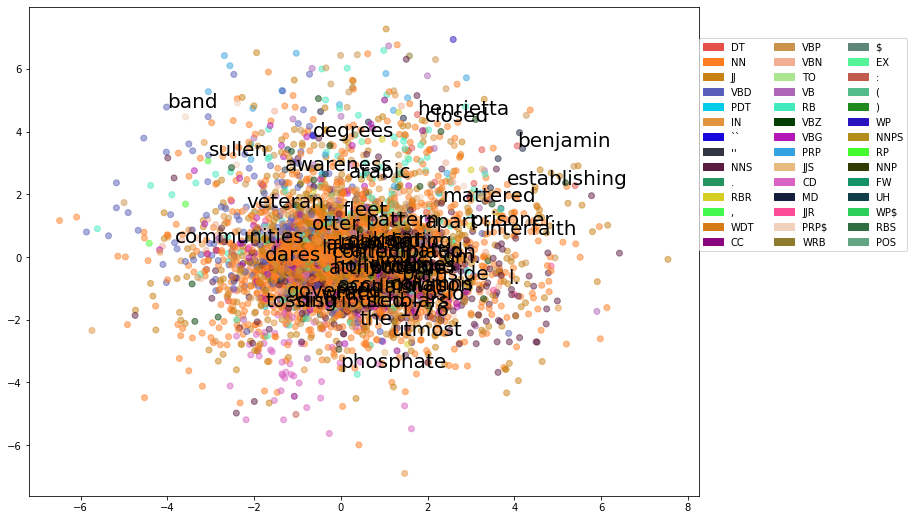

In [21]:
import matplotlib.patches as mpatches

# Color Mapping
colors = {}
for thing in df_tag['pos']:
  if thing not in colors.keys():
    colors[thing] = "#" + "".join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])

colormap = df_tag['pos'].map(colors)

# Creating a Larger Figure Size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9

# Scatter Plots
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], marker='o', alpha=0.5, c=colormap)

# Legends and Annotation
handles = [mpatches.Patch(color=colors[key], label=key) for key in colors]
plt.legend(handles=handles, ncol=3, loc=(1, 0.5))
for i, word in enumerate(np.random.choice(unique_words, 50)):
  plt.annotate(word, xy =(transformed_data[i, 0], transformed_data[i, 1]), fontsize=20)
plt.show()

Nltk also has a help function which describes the part of speech a word belongs to.

In [22]:
nltk.download('tagsets')
nltk.help.upenn_tagset()

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je j

However,this scatter plot doesn't seem to show anything really useful. It can't seem to find any meaningful patterns in the data.This isn't all that unreasonable<b> With 100 dimensional data being reduced to two dimensions</b>, we're certainly going to lose a lot explained variance. Let's <b>plot the number of components against the explained variance</b> to check:

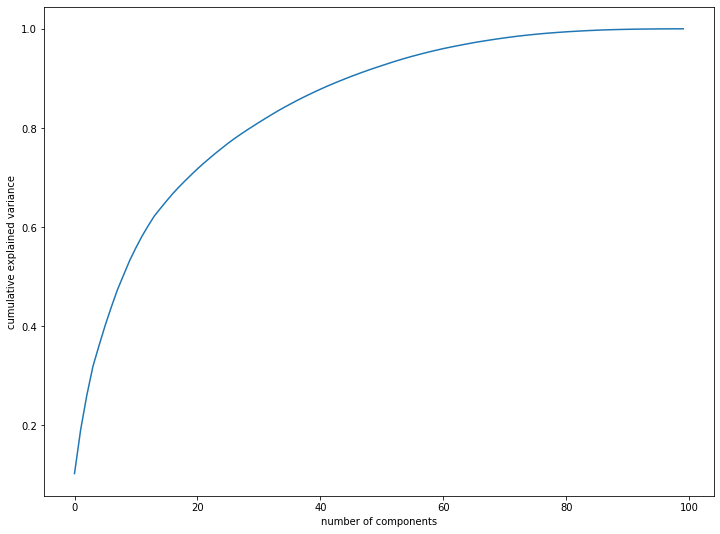

In [23]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Our plot seems to verify our suspicions i.e we simply can't see anything meaningful because  <b>two dimensions only explains 10-15% of our variance</b>.

## Sliding Window

### What is a sliding window?

A sliding window is a number of "latest" words which are actually passed into our neural network. Suppose the value was 5. Then, if we give our neural network a sentence like "The color of my house is red. What color is your", we will pass into our neural network: [".", "What", "color", "is", "your"], an array of length 5. This is done so that we have a standard number of inputs which we give our neural network.

We'll pick a sliding window size of 10. Also, some methods are defined here to grab the word vectors and create masks, which make sure that all sentences are longer than our sliding window's value, and that all the vocabulary in the sentence is part our our Word2Vec vocabulary.

In [0]:
def get_word_vector(word):
  global w2v_model
  
  try:
    wv = w2v_model.wv[word]#.reshape(-1, 1)
    if len(wv) > 0:
      return wv
  except KeyError:
      return None
  return None

In [25]:
def mask_sliding_window(df, sliding_window):
  mask = df['tokenized_sentences'].str.len() > SLIDING_WINDOW
  df = df[mask]

  df['first_' + str(SLIDING_WINDOW) + '_words'] = df['tokenized_sentences'].map(lambda a: np.array([get_word_vector(i) for i in a[:SLIDING_WINDOW]]))
  df['next_word_after_' + str(SLIDING_WINDOW) + '_words'] = df['tokenized_sentences'].map(lambda a: a[SLIDING_WINDOW])

  mask1 = df['first_' + str(SLIDING_WINDOW) + '_words'].map(lambda a: a.shape == (SLIDING_WINDOW, 100))#(SLIDING_WINDOW, 100, 1))
  df = df[mask1]

  mask2 = df['next_word_after_' + str(SLIDING_WINDOW) + '_words'].map(lambda a: type(a) == str)
  df = df[mask2]
  return df

print('Original df shape:', df.shape)
SLIDING_WINDOW = 10
df = mask_sliding_window(df, SLIDING_WINDOW)
print('New df shape:', df.shape)
df.head()

Original df shape: (57340, 2)
New df shape: (27751, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tokenized_sentences,sentences,first_10_words,next_word_after_10_words
0,"[the, fulton, county, grand, jury, said, frida...",The Fulton County Grand Jury said Friday an in...,"[[-0.11586871, -0.58114296, 0.7003871, -0.0144...",atlanta's
3,"[``, only, a, relative, handful, of, such, rep...",`` Only a relative handful of such reports was...,"[[1.6806201, 0.4940598, -1.6531188, 0.19638857...",''
4,"[the, jury, said, it, did, find, that, many, o...",The jury said it did find that many of Georgia...,"[[-0.11586871, -0.58114296, 0.7003871, -0.0144...",registration
5,"[it, recommended, that, fulton, legislators, a...",It recommended that Fulton legislators act `` ...,"[[1.5601397, -2.0488808, -0.962237, 0.07674179...",laws
6,"[the, grand, jury, commented, on, a, number, o...",The grand jury commented on a number of other ...,"[[-0.11586871, -0.58114296, 0.7003871, -0.0144...",","


Now we have done a Word2Vec on all the first_10_words. We don't need to do a Word2Vec on the next_word_after_10_words because we will now be getting a class vector for the words. This is basically like "one-hot encoding" the words—we will get an array of the size of our vocabulary, which will be filled almost entirely with 0s except for a 1 denoting our target word.

In [26]:
def get_class_vec(word):
    temp = np.zeros(len(unique_words), dtype = np.int8)
    try:
      temp[unique_words.index(word)] = 1
    except ValueError:
      pass
    return temp
   
df['class_vec'] = df['next_word_after_' + str(SLIDING_WINDOW) + '_words'].map(lambda a: get_class_vec(a))
df.head()

,tokenized_sentences,sentences,first_10_words,next_word_after_10_words,class_vec
0,"[the, fulton, county, grand, jury, said, frida...",The Fulton County Grand Jury said Friday an in...,"[[-0.11586871, -0.58114296, 0.7003871, -0.0144...",atlanta's,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[``, only, a, relative, handful, of, such, rep...",`` Only a relative handful of such reports was...,"[[1.6806201, 0.4940598, -1.6531188, 0.19638857...",'',"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[the, jury, said, it, did, find, that, many, o...",The jury said it did find that many of Georgia...,"[[-0.11586871, -0.58114296, 0.7003871, -0.0144...",registration,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,"[it, recommended, that, fulton, legislators, a...",It recommended that Fulton legislators act `` ...,"[[1.5601397, -2.0488808, -0.962237, 0.07674179...",laws,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,"[the, grand, jury, commented, on, a, number, o...",The grand jury commented on a number of other ...,"[[-0.11586871, -0.58114296, 0.7003871, -0.0144...",",","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Our pre-processing is looking great! Let's move on to the RNN.

## The RNN

Now, we're going to create our RNN, which will take in our input vector and predict the next word. This is a classification task, as we need to predict one word out of the individual word classes in our entire vocabulary.


### LSTM

##### What is going on here?

We're adding layers to our sequential model. Firstly, we'll use <b>3 LSTM layers</b> to create a multi-dimensional recurrent neural network. LSTMs are useful for us because they allow us to go back a certain amount of words once we have a result and continue training. Since we set a sliding window earlier, we can give our <b>LSTM an input size with width equal to the sliding window. The LSTM will then train one word in the past, get a result, and then train the same result with two words into the past</b>, etc... This is incredibly helpful to us because we want to be able to look a certain depth into the past to predict our next word.

Out of experimentation, we found that using many LSTM layers is better, so we've added three. A Dropout layer helps us with overfitting—it takes out a certain amount of random terms from our LSTM system in order to cross validate on them. The Dense layer and Activation allow us to actually get a probability for each word. We do want this because we want to predict more than one word sometimes (such as in iOS, where three words are shown above the keypad), and so knowing the probabilities of each word will help us sort the word predictions from most likely to least likely.

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation

def create_LSTM_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape=(None, 100)))
    model.add(LSTM(128, return_sequences = True, input_shape=(None, 100)))
    model.add(LSTM(128, input_shape=(None, 100)))
    model.add(Dropout(0.2))
    model.add(Dense(len(unique_words)))
    model.add(Activation('softmax'))
    return model
  
model = create_LSTM_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 14221)             1834509   
_________________________________________________________________
activation (Activation)      (None, 14221)             0         
Total params: 2,214,925
Trainable params:

<b>Now, we can split our dataset into train and test sets, and then format the data such that it's the right shape for our network.

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df)
train_features = 'first_' + str(SLIDING_WINDOW) + '_words'

train_target = 'next_word_after_' + str(SLIDING_WINDOW) + '_words'

In [29]:
X = train['first_' + str(SLIDING_WINDOW) + '_words'].values #get numpy arrays of values
y = train['class_vec'].values
X = np.array([i for i in X]) #makes sure shape is correct
y = np.array([i for i in y])
print(X.shape)
print(y.shape)

(20813, 10, 100)
(20813, 14221)


In [30]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # Saving weights, every 5-epochs.
    period=5)

In [31]:
from tensorflow.train import RMSPropOptimizer

LEARNING_RATE = 0.01
EPOCHS = 6 

optimizer = RMSPropOptimizer(LEARNING_RATE) # good choice for RNNs

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X,
                    y,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_split = 0.1,
                    verbose=1,
                    callbacks = [cp_callback], shuffle = True).history


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 18731 samples, validate on 2082 samples
Epoch 1/6
18731/18731 [==============================] - 30s 2ms/sample - loss: 8.1780 - acc: 0.0672 - val_loss: 6.8990 - val_acc: 0.1085
Epoch 2/6
18731/18731 [==============================] - 28s 1ms/sample - loss: 6.4404 - acc: 0.1006 - val_loss: 6.2326 - val_acc: 0.1369
Epoch 3/6
18731/18731 [==============================] - 28s 1ms/sample - loss: 5.9547 - acc: 0.1382 - val_loss: 6.0668 - val_acc: 0.1470
Epoch 4/6
18731/18731 [==============================] - 28s 2ms/sample - loss: 5.7455 - acc: 0.1478 - val_loss: 6.0352 - val_acc: 0.1422
Epoch 5/6
18688/18731 [============================>.] - ETA: 0s - loss: 5.6030 - acc: 0.1577
Epoch 00005: saving model to training_2/cp-0005.ckpt
18731/18731 [===========================

This part is just for saving and reloading a pre-trained version of our model, and isn't necessary to run.

In [32]:
print(os.listdir())
print(os.listdir('training_2'))
latest = tf.train.latest_checkpoint('training_2')
print(latest)

['.config', 'training_2', 'sample_data']
['cp-0005.ckpt.index', 'cp-0005.ckpt.data-00000-of-00002', 'cp-0005.ckpt.data-00001-of-00002', 'checkpoint']
training_2/cp-0005.ckpt


In [33]:
model.load_weights(latest)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
try:
   loss, acc = model.evaluate(X, y)
except:
   print('Pre-trained model not found')

print("Restored model, accuracy: {:5.2f}%".format(100*acc))

20813/20813 [==============================] - 15s 717us/sample - loss: 5.2229 - acc: 0.1717
Restored model, accuracy: 17.17%


### Evaluation


Let's evaluate our model. The following methods help split up a normal sentence into tokens. The predict method is useful to define now because we will use it quite a bit to test.

In [0]:
import re

def sent_vec(tok_sent):
  output = []
  for word in tok_sent:
    if(type(get_word_vector(word.lower())) == np.ndarray):
       output.append([get_word_vector(word.lower())])
  return np.expand_dims(np.array(output).squeeze(), axis = 0)

def predict(model, sent, num_results=1):
  tok_sent = sent.replace('.', ' .')
  tok_sent = tok_sent.replace(',', ' ,')
  tok_sent = tok_sent.split(' ') #re.split('[,. ]', sent)
  assert len(tok_sent) >= SLIDING_WINDOW, "Please input a sentence of length " + str(SLIDING_WINDOW) + " or greater!"
  word_model = model.predict(sent_vec(tok_sent))
  first_N_words_idx = np.flip(word_model.argsort()[0], 0)[:num_results]
  first_N_words = []
  for word_idx in first_N_words_idx:
    first_N_words.append(unique_words[word_idx])
  if num_results > 1:
    return first_N_words
  return first_N_words[0]

In [35]:
word_model = predict(model, 'Call me Ishmael. Some years ago - never mind', 4)

word_model

['.', ',', 'to', "''"]

In [0]:
def generate_paragraph(model, sent, words_to_add):
  result = sent
  for i in range(words_to_add):
    result = result + ' ' + predict(model, result)
  return result

In [37]:
generate_paragraph(model, "When he was nearly thirteen, my brother Jem got his arm badly broken at the", 10)

"When he was nearly thirteen, my brother Jem got his arm badly broken at the . . . . '' . you said . ."

In [38]:
generate_paragraph(model, "It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness,", 10)

'It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, the the . of the the . . of the'

Now, let's test our trained LSTM on our test set to see our test accuracy.

In [39]:
X_test = test['first_' + str(SLIDING_WINDOW) + '_words'].values
y_test = test['class_vec'].values

X_test = np.array([i for i in X_test])
y_test = np.array([i for i in y_test])
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy: {:5.2f}%".format(100*test_acc))

6938/6938 [==============================] - 5s 694us/sample - loss: 5.9815 - acc: 0.1538
Test accuracy: 15.38%


Why are so many words being repeated?

After a while the model gets lost in its own wording. Since it only takes 10 words in the past, if all of the 10 words are the model's own words, then naturally, we can expect that the model will become less and less guided over time.

This is also a result of underfitting. In order to predict more successfully, we may, in the future, have a larger sliding window, or a flexible sliding window. We would definitely need a far larger dataset to make real-world predictions, like iOS does. But for our small(ish) datasets and small(ish) epochs, it looks like we've done fine.

By plotting accuracy and loss against the progression of epochs in our model training history, we can estimate the optimal number of epochs.

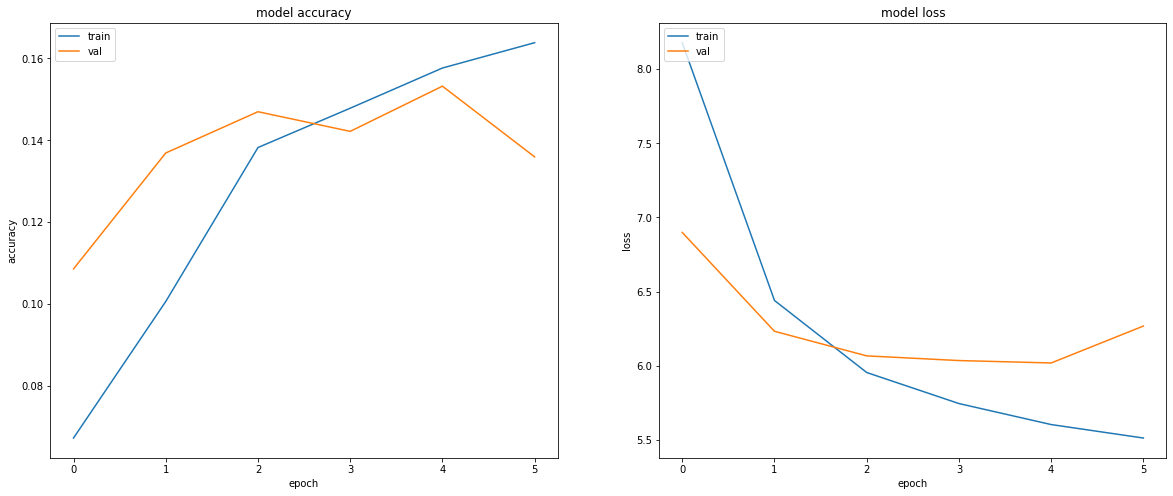

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(history['acc'])
ax[0].plot(history['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history['loss'])
ax[1].plot(history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()

On the whole, these diagrams are fair. We should expect that train accuracy and test accuracy go up (although naturally, train accuracy will be far better), and that train loss and test loss go down (and test loss will be higher). The problems stated above are reflected in the diagrams.

### Training Other Corpora

This is the basic structure of our program, all in one method. All of the hyper-parameters are parameters of this method.

In [0]:
def rnn_predict_words(sentences, blacklist=None, sliding_window=10, save_period=5, alpha=0.01, word_epochs=20, rnn_epochs=12, batch_size=128, validation_split=0.1, verbose=1):
  print('Loading dataframe...')
  df = pd.DataFrame(sentences, columns = ['tokenized_sentences'])

  def clean_sents(arr):
    result = [word.lower() for word in arr]
    if blacklist != None:
      for word in blacklist:
        result = list(filter(lambda x: x != word, result))
    return result

  print('Cleaning sentences...')
  df['tokenized_sentences'] = df['tokenized_sentences'].map(clean_sents)
  
  print('Creating a Word2Vec model...')
  w2v_model = create_w2v_model(df, word_epochs)
  unique_words = list(w2v_model.wv.vocab)
  df = mask_sliding_window(df, sliding_window)
  df['class_vec'] = df['next_word_after_' + str(sliding_window) + '_words'].map(lambda a: get_class_vec(a))

  print('Splitting train/test...')
  model = create_LSTM_model()
  train, test = train_test_split(df)
  train_features = 'first_' + str(sliding_window) + '_words'

  train_target = 'next_word_after_' + str(sliding_window) + '_words'
  X = train['first_' + str(sliding_window) + '_words'].values
  y = train['class_vec'].values
  X = np.array([i for i in X])
  y = np.array([i for i in y])

  print('Creating checkpoints...')
  checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  cp_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_path, verbose=1, save_weights_only=True,
      period=save_period)

  optimizer = RMSPropOptimizer(alpha)

  print('Training...')
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X,
                      y,
                      epochs=rnn_epochs,
                      batch_size=batch_size,
                      validation_split = validation_split,
                      verbose=verbose,
                      callbacks=[cp_callback],
                      shuffle=True).history
  return model

Now we can test our model trained on different text corpora. Here we've done the Brown corpus (compilation of text from 500 sources of varied genres), the Web Text corpus (more informal text from conversations, movie scripts, reviews, and advertisements), and the Inaugural Address corpus (collection of text from the 55 presidential addresses). More options of text corpora can be found here: https://www.nltk.org/book/ch02.html.

In [43]:
nltk.download('brown')
from nltk.corpus import brown
brown_sents = np.array(brown.sents()).reshape(-1, 1)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [69]:
nltk.download('webtext')
from nltk.corpus import webtext
webtext_sents = np.array(webtext.sents()).reshape(-1, 1)

[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


In [70]:
nltk.download('inaugural')
from nltk.corpus import inaugural
inaugural_sents = np.array(inaugural.sents()).reshape(-1, 1)

[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.


We start by cleaning our data for punctuation. We can try training the data with and without punctuation and compare the results to see if there is a significant change in quality.

In [72]:
brown_wo_punc = rnn_predict_words(brown_sents, blacklist=['.', ',', '\'', '\"', ';', ':', '[', ']', '--', '-', '!', '?'])
brown_w_punc = rnn_predict_words(brown_sents)
webtext_wo_punc = rnn_predict_words(webtext_sents, blacklist=['.', ',', '\'', '\"', ';', ':', '[', ']', '--', '-', '!', '?'])
webtext_w_punc = rnn_predict_words(webtext_sents)
inaugural_wo_punc = rnn_predict_words(inaugural_sents, blacklist=['.', ',', '\'', '\"', ';', ':', '[', ']', '--', '-', '!', '?'])
inaugural_w_punc = rnn_predict_words(inaugural_sents)

Loading dataframe...
Cleaning sentences...
Creating a Word2Vec model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Splitting train/test...
Creating checkpoints...
Training...
Train on 16821 samples, validate on 1869 samples
Epoch 1/12
16821/16821 [==============================] - 29s 2ms/sample - loss: 8.4017 - acc: 0.0944 - val_loss: 7.0730 - val_acc: 0.0262
Epoch 2/12
16821/16821 [==============================] - 26s 2ms/sample - loss: 6.7422 - acc: 0.1103 - val_loss: 6.6483 - val_acc: 0.1220
Epoch 3/12
16821/16821 [==============================] - 26s 2ms/sample - loss: 6.2899 - acc: 0.1292 - val_loss: 6.5594 - val_acc: 0.1273
Epoch 4/12
16821/16821 [==============================] - 26s 2ms/sample - loss: 6.0624 - acc: 0.1414 - val_loss: 6.4502 - val_acc: 0.1289
Epoch 5/12
16768/16821 [============================>.] - ETA: 0s - loss: 5.9050 - acc: 0.1447
Epoch 00005: saving model to training_2/cp-0005.ckpt
16821/16821 [==============================] - 27s 2ms/sample - loss: 5.9060 - acc: 0.1446 - val_loss: 6.4189 - val_acc: 0.1364
Epoch 6/12
16821/16821 [==============================] - 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Splitting train/test...
Creating checkpoints...
Training...
Train on 16821 samples, validate on 1869 samples
Epoch 1/12
16821/16821 [==============================] - 28s 2ms/sample - loss: 8.4374 - acc: 0.0935 - val_loss: 7.0322 - val_acc: 0.0289
Epoch 2/12
16821/16821 [==============================] - 25s 2ms/sample - loss: 6.7748 - acc: 0.1108 - val_loss: 6.5975 - val_acc: 0.1380
Epoch 3/12
16821/16821 [==============================] - 25s 2ms/sample - loss: 6.3191 - acc: 0.1357 - val_loss: 6.4717 - val_acc: 0.1461
Epoch 4/12
16821/16821 [==============================] - 26s 2ms/sample - loss: 6.0985 - acc: 0.1392 - val_loss: 6.3792 - val_acc: 0.1525
Epoch 5/12
16768/16821 [============================>.] - ETA: 0s - loss: 5.9194 - acc: 0.1466
Epoch 00005: saving model to training_2/cp-0005.ckpt
16821/16821 [==============================] - 27s 2ms/sample - loss: 5.9217 - acc: 0.1466 - val_loss: 6.3416 - val_acc: 0.1327
Epoch 6/12
16821/16821 [==============================] - 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Splitting train/test...
Creating checkpoints...
Training...
Train on 1649 samples, validate on 184 samples
Epoch 1/12
1649/1649 [==============================] - 6s 3ms/sample - loss: 8.6169 - acc: 0.0012 - val_loss: 8.6776 - val_acc: 0.0000e+00
Epoch 2/12
1649/1649 [==============================] - 3s 2ms/sample - loss: 8.6149 - acc: 0.0309 - val_loss: 8.6748 - val_acc: 0.0815
Epoch 3/12
1649/1649 [==============================] - 3s 2ms/sample - loss: 8.6104 - acc: 0.1116 - val_loss: 8.6693 - val_acc: 0.0978
Epoch 4/12
1649/1649 [==============================] - 2s 1ms/sample - loss: 8.6019 - acc: 0.1273 - val_loss: 8.6586 - val_acc: 0.1033
Epoch 5/12
1536/1649 [==========================>...] - ETA: 0s - loss: 8.5734 - acc: 0.1296
Epoch 00005: saving model to training_2/cp-0005.ckpt
1649/1649 [==============================] - 4s 2ms/sample - loss: 8.5857 - acc: 0.1292 - val_loss: 8.6382 - val_acc: 0.1033
Epoch 6/12
1649/1649 [==============================] - 3s 2ms/sample - lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Splitting train/test...
Creating checkpoints...
Training...
Train on 1649 samples, validate on 184 samples
Epoch 1/12
1649/1649 [==============================] - 6s 4ms/sample - loss: 8.6229 - acc: 6.0643e-04 - val_loss: 8.6261 - val_acc: 0.0000e+00
Epoch 2/12
1649/1649 [==============================] - 2s 2ms/sample - loss: 8.6208 - acc: 0.0158 - val_loss: 8.6230 - val_acc: 0.0761
Epoch 3/12
1649/1649 [==============================] - 3s 2ms/sample - loss: 8.6168 - acc: 0.0631 - val_loss: 8.6170 - val_acc: 0.1033
Epoch 4/12
1649/1649 [==============================] - 3s 2ms/sample - loss: 8.6086 - acc: 0.0752 - val_loss: 8.6053 - val_acc: 0.1304
Epoch 5/12
1536/1649 [==========================>...] - ETA: 0s - loss: 8.5802 - acc: 0.1257
Epoch 00005: saving model to training_2/cp-0005.ckpt
1649/1649 [==============================] - 4s 2ms/sample - loss: 8.5934 - acc: 0.1231 - val_loss: 8.5834 - val_acc: 0.1304
Epoch 6/12
1649/1649 [==============================] - 3s 2ms/sample 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Splitting train/test...
Creating checkpoints...
Training...
Train on 2029 samples, validate on 226 samples
Epoch 1/12
2029/2029 [==============================] - 7s 3ms/sample - loss: 9.2124 - acc: 0.0064 - val_loss: 9.2619 - val_acc: 0.1062
Epoch 2/12
2029/2029 [==============================] - 3s 2ms/sample - loss: 9.2061 - acc: 0.1010 - val_loss: 9.2515 - val_acc: 0.1283
Epoch 3/12
2029/2029 [==============================] - 3s 1ms/sample - loss: 9.1920 - acc: 0.1109 - val_loss: 9.2289 - val_acc: 0.1283
Epoch 4/12
2029/2029 [==============================] - 3s 1ms/sample - loss: 9.1622 - acc: 0.1114 - val_loss: 9.1806 - val_acc: 0.1283
Epoch 5/12
1920/2029 [===========================>..] - ETA: 0s - loss: 9.0484 - acc: 0.1120
Epoch 00005: saving model to training_2/cp-0005.ckpt
2029/2029 [==============================] - 5s 2ms/sample - loss: 9.0338 - acc: 0.1114 - val_loss: 8.6131 - val_acc: 0.1283
Epoch 6/12
2029/2029 [==============================] - 3s 2ms/sample - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Splitting train/test...
Creating checkpoints...
Training...
Train on 2029 samples, validate on 226 samples
Epoch 1/12
2029/2029 [==============================] - 7s 3ms/sample - loss: 9.2075 - acc: 0.0113 - val_loss: 9.3041 - val_acc: 0.0841
Epoch 2/12
2029/2029 [==============================] - 3s 2ms/sample - loss: 9.2015 - acc: 0.0966 - val_loss: 9.2939 - val_acc: 0.1195
Epoch 3/12
2029/2029 [==============================] - 3s 2ms/sample - loss: 9.1882 - acc: 0.1089 - val_loss: 9.2724 - val_acc: 0.1195
Epoch 4/12
2029/2029 [==============================] - 3s 2ms/sample - loss: 9.1607 - acc: 0.1094 - val_loss: 9.2295 - val_acc: 0.1195
Epoch 5/12
1920/2029 [===========================>..] - ETA: 0s - loss: 9.1032 - acc: 0.1089
Epoch 00005: saving model to training_2/cp-0005.ckpt
2029/2029 [==============================] - 5s 2ms/sample - loss: 9.0830 - acc: 0.1094 - val_loss: 8.9488 - val_acc: 0.1195
Epoch 6/12
2029/2029 [==============================] - 3s 2ms/sample - loss: 

After training, we can take a look at the accuracy and loss history plots.

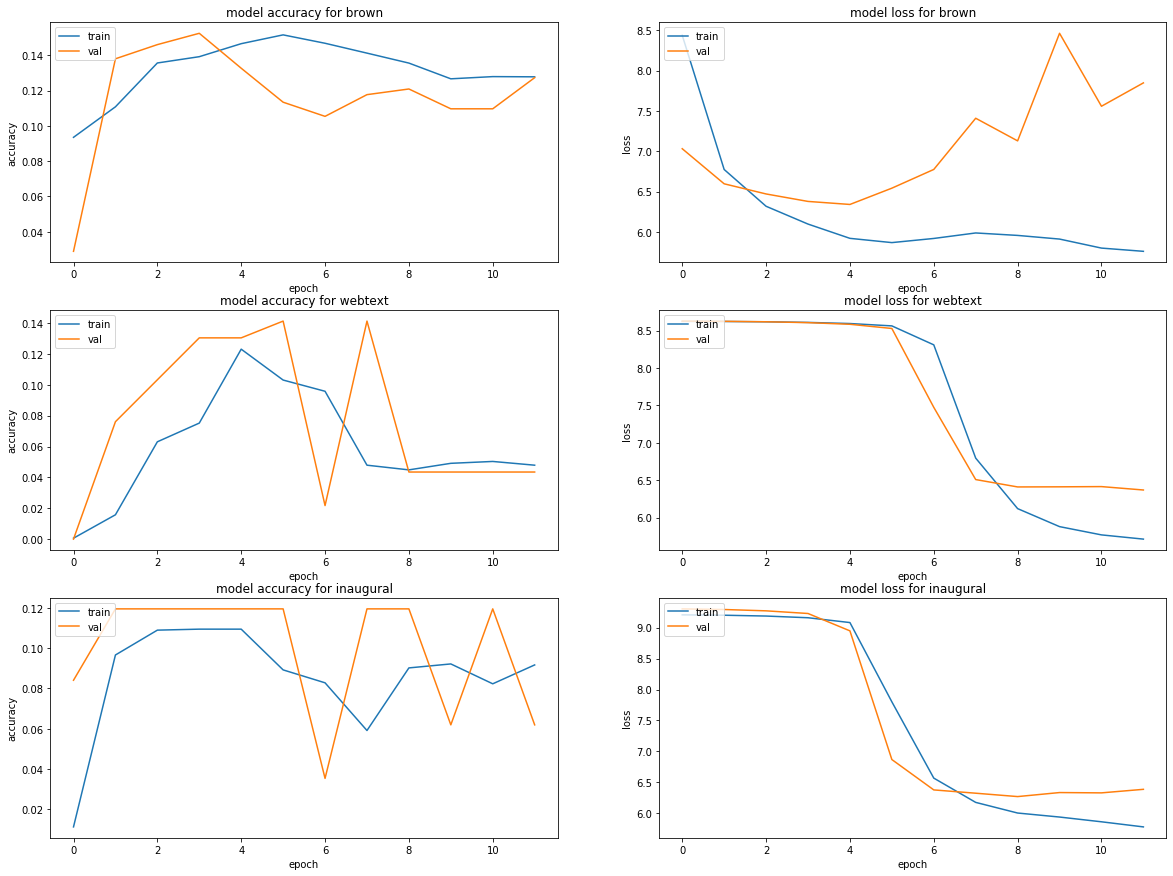

In [74]:
fig, ax = plt.subplots(3,2,figsize=(20, 15))
ax[0][0].plot(brown_w_punc.history.history['acc'])
ax[0][0].plot(brown_w_punc.history.history['val_acc'])
ax[0][0].set_title('model accuracy for brown')
ax[0][0].set_ylabel('accuracy')
ax[0][0].set_xlabel('epoch')
ax[0][0].legend(['train', 'val'], loc='upper left')
ax[0][1].plot(brown_w_punc.history.history['loss'])
ax[0][1].plot(brown_w_punc.history.history['val_loss'])
ax[0][1].set_title('model loss for brown')
ax[0][1].set_ylabel('loss')
ax[0][1].set_xlabel('epoch')
ax[0][1].legend(['train', 'val'], loc='upper left')

ax[1][0].plot(webtext_w_punc.history.history['acc'])
ax[1][0].plot(webtext_w_punc.history.history['val_acc'])
ax[1][0].set_title('model accuracy for webtext')
ax[1][0].set_ylabel('accuracy')
ax[1][0].set_xlabel('epoch')
ax[1][0].legend(['train', 'val'], loc='upper left')

ax[1][1].plot(webtext_w_punc.history.history['loss'])
ax[1][1].plot(webtext_w_punc.history.history['val_loss'])
ax[1][1].set_title('model loss for webtext')
ax[1][1].set_ylabel('loss')
ax[1][1].set_xlabel('epoch')
ax[1][1].legend(['train', 'val'], loc='upper left')

ax[2][0].plot(inaugural_w_punc.history.history['acc'])
ax[2][0].plot(inaugural_w_punc.history.history['val_acc'])
ax[2][0].set_title('model accuracy for inaugural')
ax[2][0].set_ylabel('accuracy')
ax[2][0].set_xlabel('epoch')
ax[2][0].legend(['train', 'val'], loc='upper left')

ax[2][1].plot(inaugural_w_punc.history.history['loss'])
ax[2][1].plot(inaugural_w_punc.history.history['val_loss'])
ax[2][1].set_title('model loss for inaugural')
ax[2][1].set_ylabel('loss')
ax[2][1].set_xlabel('epoch')
ax[2][1].legend(['train', 'val'], loc='upper left')

plt.show()

It seems like the model found the most success with the Inaugural Address corpus, although the model's improvement seems to slow after 6-8 epochs for all of the corpora.

In [76]:
print('Brown without punc:', generate_paragraph(brown_wo_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))

Brown without punc: When he was nearly thirteen, my brother Jem got his arm badly broken and caused the first for the for the the the


In [77]:
print('Brown with punc:', generate_paragraph(brown_w_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))

Brown with punc: When he was nearly thirteen, my brother Jem got his arm badly broken and the slight young and the `` other people and


In [78]:
print('Webtext without punc:', generate_paragraph(webtext_wo_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))
print('Webtext with punc:', generate_paragraph(webtext_w_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))
print('Inaugural without punc:', generate_paragraph(inaugural_wo_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))
print('Inaugural with punc:', generate_paragraph(inaugural_w_punc, "When he was nearly thirteen, my brother Jem got his arm badly broken", 10))

Webtext without punc: When he was nearly thirteen, my brother Jem got his arm badly broken of of of of of of of of of of
Webtext with punc: When he was nearly thirteen, my brother Jem got his arm badly broken a a a a a a a a a a
Inaugural without punc: When he was nearly thirteen, my brother Jem got his arm badly broken to to to to to to to to to to
Inaugural with punc: When he was nearly thirteen, my brother Jem got his arm badly broken of of of of of of of of of of
